Text(0.5, 0.92, 'Trajectory of all particles in 3D')

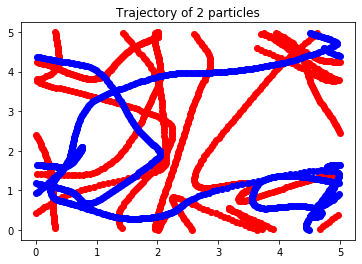

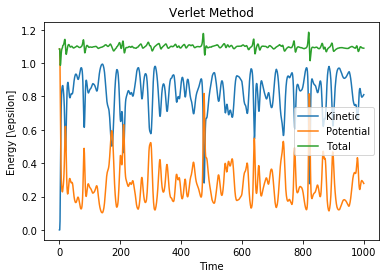

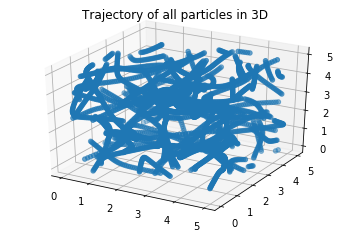

In [116]:
import numpy as np
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation



eps = 1 #119.8*1.38*10**-23
sigma = 1 #3.405E-10
mass = 1 #6.6E-26 
N = 5
D = 3
L = 5*sigma #*np.sqrt(N/D)
dt = 1e-1*np.sqrt(mass*sigma**2/eps)
Timesteps = 1000 #timesteps


def createCoordinate(Numberparticles, Dimension):
    return np.random.random((Numberparticles,Dimension))*L

def createVelocity(Numberparticles, Dimension):
    return np.random.random((Numberparticles,Dimension))

def calculateDistance(r):
    N = r.shape[0]
    D = r.shape[1]
        
    bigR = np.broadcast_to(r, (N, N, D))
    bigRT = np.transpose(bigR, (1, 0, 2))
    
    deltaR = bigR - bigRT
    
    # minimal image implementation
    deltaR = (deltaR + L/2)%L - L/2
    
    return deltaR

def calculateForce(r):
    deltaR = calculateDistance(r)
    
    normR = np.linalg.norm(deltaR, axis = 2, keepdims = True)
    mask = np.eye(N, dtype = bool)
    normR[mask,:] = 1
    
    
    deltaU = 4*eps*(6*sigma**6/normR**8 - 12*sigma**12/normR**14)*deltaR
    F = -np.sum(deltaU, axis = 1 )
    
    return F

def eulerMethod(r, v):
    F = calculateForce(r)
    v = v + 1/mass*F*dt
    r = r + v*dt
    
    # boundary
    r = r%L
    return r, v



def potentialEnergy(r):
    deltaR = calculateDistance(r)
    normR = np.linalg.norm(deltaR, axis = 2)
    mask = np.eye(N, dtype = bool)

    normR[mask] = 1
    
    U = 4*eps*(sigma**12/normR**12 - sigma**6/normR**6 )
    U[mask] = 0
 
    Utot = 0.5*np.sum(U)
    return np.abs(Utot)


def kineticEnergy(v):
    return np.sum(0.5*mass*np.linalg.norm(v)**2)

def velocityGauss(N, D):
    mu, sigma = 0, np.sqrt(kb*T/mass)
    return np.random.normal(mu, sigma, (N,D))


# initilazing the coordinates and velocities
r = np.zeros((N, D, Timesteps))
r[:,:,0] = createCoordinate(N, D)
v = velocityGauss(N, D)*0                    
F = calculateForce(r[:,:,0])

# initilazing the Energies
kineticE = np.zeros(Timesteps)
potentialE = np.zeros(Timesteps)
kineticE[0] = kineticEnergy(v)
potentialE[0] = potentialEnergy(r[:,:,0])

for i in range(1,Timesteps):
    kineticE[i] = kineticEnergy(v)
    potentialE[i] = potentialEnergy(r[:,:,i-1])
    r[:,:,i], v = eulerMethod(r[:,:,i-1] , v)
    
    # verlet algorithm
    #r[:,:,i] = r[:,:,i-1] + dt*v + 0.5*calculateForce(r[:,:,i-1])*dt**2
    #r[:,:,i] = r[:,:,i]%L
    #v = v + 0.5*dt*(calculateForce(r[:,:,i])+ calculateForce(r[:,:,i-1]) )


 
################################################################################################
################################# Plots #########################################################    
plt.plot(r[0,0,:], r[0,1,:], 'ro')
plt.plot(r[1,0,:], r[1,1,:], 'bo')
plt.title("Trajectory of 2 particles")



plt.figure()
plt.plot(np.arange(Timesteps), kineticE, label = "Kinetic" )
plt.plot(np.arange(Timesteps), potentialE, label = "Potential")
plt.plot(np.arange(Timesteps), potentialE + kineticE, label =  "Total")

plt.ylabel("Energy [\epsilon]")
plt.xlabel("Time")
plt.title("Verlet Method")
plt.legend()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(r[:,0,:], r[:,1,:], r[:,2,:], zdir='z')
plt.title("Trajectory of all particles in 3D")




 


In [111]:
kb = 1
T = 1
def velocityGauss(N, D):
    kb = 1.23e-23
    T = 300
    mass = 6.6e-26
    mu, sigma = 0, np.sqrt(kb*T/mass)
    return np.random.normal(mu, sigma, (N,D))
vv = velocityGauss(N,D)
print(vv)

[[-154.09602391 -251.6448428  -127.33059235]
 [-186.29027159  -45.35545031  -82.26026628]
 [  81.39619563 -183.89575878  316.50109426]
 [ 341.41205271  132.71621746  223.28802887]
 [-178.50901322  162.20537102 -255.63726731]]
